# Modeling Task Relationships in Multi-task Learning with Multi-gate Mixture-of-Experts

This notebook will reproduce an excellent work of Google on multi task learning, [**Modeling Task Relationships in Multi-task Learning with Multi-gate Mixture-of-Experts**](https://dl.acm.org/doi/pdf/10.1145/3219819.3220007). 
The paper proposed a multi-task learning approach named Multi-gate Mixture-of-Experts(MMoE) which explicitly learns
to model task relationships from data, and studied the tradeoffs between task-specic objectives and inter-task relationships. The MMoE model is adapted from the Mixture-of-Experts (MoE) structure to multi-task learning by sharing the expert submodels across all tasks, while also having a gating network trained to optimize each task.

Our work in the notebook can be summarized as follows:
- implements the MoE, MMoE, shared-bottom model under the two regression task setting
- compare the performance of MMoE with baselines at different levels of task relatedness

The dataset used here is synthesized according to the paper. The work coverd here is corresponding to the following sections of the paper: 
- Section 3. PRELIMINARY
- Section 5. MMOE ON SYNTHETIC DATA

In [1]:
import matplotlib.pyplot as plt
from paperlab.core import Config, ExpRunner
from paperlab.zoo import mmoe
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
conf = {
    "train_data_size": 1000000,
    "dev_data_size": 5000,
    "num_sin_params": 4,
    "model": "moe",
    "model_arch.dim_in": 100,
    "model_arch.dim_hidden_bottom": 16,
    "model_arch.dim_hidden_tower": 8,
    "model_arch.num_expert": 8,
    "model_arch.num_task": 2,
    "num_epoch": 100,
    "batch_size": 40,
    "lr": 5e-4,
    "task_corr": 0.1,
    "validate_freq": 10000
}

# Performance of the Shared-Bottom model on synthetic data with different task correlation

In [3]:
def process_result(exp_runner):
    df_source = []
    for result in exp_runner.exp_results:
        df_source.append(dict(result))
    # process mean value from each single run
    return pd.DataFrame(df_source).mean()

In [4]:
config = Config(**conf)
config.model = 'shared_bottom'
# hard set the dimensionality of the bottom net to reach a comparable parameter number with MMoE and MoE
config.model_arch.dim_hidden_bottom = 113
print(config)

{'train_data_size': 1000000, 'dev_data_size': 5000, 'num_sin_params': 4, 'model': 'shared_bottom', 'model_arch': {'dim_in': 100, 'dim_hidden_bottom': 113, 'dim_hidden_tower': 8, 'num_expert': 8, 'num_task': 2}, 'num_epoch': 100, 'batch_size': 40, 'lr': 0.0005, 'task_corr': 0.1, 'validate_freq': 10000}


In [5]:
shared_bottom_stats = {}

for task_corr in [0.5, 0.9, 1.0]:
    config.task_corr = task_corr  # change the task correlation
    
    # set up experiment runner, repeat running 10 times under different random seed
    runner = ExpRunner(mmoe.exp, {'config': config}, repeat_num=8)
    runner.run_mp()  # run exp under multi-processing setting
    
    series = process_result(runner)
    shared_bottom_stats[task_corr] = series

experiment starts ...
repeat running 8 times, random seeds are [0, 1, 2, 3, 4, 5, 6, 7]
config:
	 config = {'train_data_size': 1000000, 'dev_data_size': 5000, 'num_sin_params': 4, 'model': 'shared_bottom', 'model_arch': {'dim_in': 100, 'dim_hidden_bottom': 113, 'dim_hidden_tower': 8, 'num_expert': 8, 'num_task': 2}, 'num_epoch': 100, 'batch_size': 40, 'lr': 0.0005, 'task_corr': 0.5, 'validate_freq': 10000}
Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to schedule

  0%|          | 0/8 [00:00<?, ?it/s]

experiment starts ...
repeat running 8 times, random seeds are [0, 1, 2, 3, 4, 5, 6, 7]
config:
	 config = {'train_data_size': 1000000, 'dev_data_size': 5000, 'num_sin_params': 4, 'model': 'shared_bottom', 'model_arch': {'dim_in': 100, 'dim_hidden_bottom': 113, 'dim_hidden_tower': 8, 'num_expert': 8, 'num_task': 2}, 'num_epoch': 100, 'batch_size': 40, 'lr': 0.0005, 'task_corr': 0.9, 'validate_freq': 10000}
Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to schedule

  0%|          | 0/8 [00:00<?, ?it/s]

experiment starts ...
repeat running 8 times, random seeds are [0, 1, 2, 3, 4, 5, 6, 7]
config:
	 config = {'train_data_size': 1000000, 'dev_data_size': 5000, 'num_sin_params': 4, 'model': 'shared_bottom', 'model_arch': {'dim_in': 100, 'dim_hidden_bottom': 113, 'dim_hidden_tower': 8, 'num_expert': 8, 'num_task': 2}, 'num_epoch': 100, 'batch_size': 40, 'lr': 0.0005, 'task_corr': 1.0, 'validate_freq': 10000}
Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to schedule

  0%|          | 0/8 [00:00<?, ?it/s]

We show the validation loss of the shared-bottom model under different task-correlation to validate the hypthesis that the task-correlation affects the performance of multi-task learning model.

Higer the task-correlation is, better the multi-task learning model perform, and vice versa.

(0.0, 0.5)

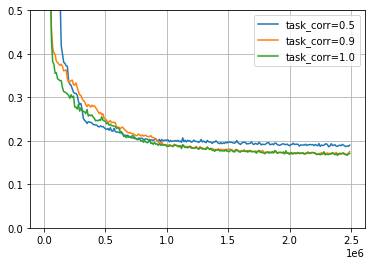

In [11]:
for task_corr in shared_bottom_stats:
    plt.plot(shared_bottom_stats[task_corr][1:], label=f'task_corr={task_corr}')

plt.legend()
plt.grid()
plt.ylim(0, 0.5)

# Performance on MMoE

In [7]:
config = Config(**conf)
config.model = 'mmoe'
config.model_arch.dim_hidden_bottom = 16

In [ ]:
mmoe_stats = {}

for task_corr in [0.5, 0.9, 1.0]:
    config.task_corr = task_corr
    runner = ExpRunner(mmoe.exp, {'config': config}, repeat_num=8)
    runner.run_mp()
    series = process_result(runner)
    mmoe_stats[task_corr] = series

experiment starts ...
repeat running 8 times, random seeds are [0, 1, 2, 3, 4, 5, 6, 7]
config:
	 config = {'train_data_size': 1000000, 'dev_data_size': 5000, 'num_sin_params': 4, 'model': 'mmoe', 'model_arch': {'dim_in': 100, 'dim_hidden_bottom': 16, 'dim_hidden_tower': 8, 'num_expert': 8, 'num_task': 2}, 'num_epoch': 100, 'batch_size': 40, 'lr': 0.0005, 'task_corr': 0.5, 'validate_freq': 10000}
Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is

  0%|          | 0/8 [00:00<?, ?it/s]

experiment starts ...
repeat running 8 times, random seeds are [0, 1, 2, 3, 4, 5, 6, 7]
config:
	 config = {'train_data_size': 1000000, 'dev_data_size': 5000, 'num_sin_params': 4, 'model': 'mmoe', 'model_arch': {'dim_in': 100, 'dim_hidden_bottom': 16, 'dim_hidden_tower': 8, 'num_expert': 8, 'num_task': 2}, 'num_epoch': 100, 'batch_size': 40, 'lr': 0.0005, 'task_corr': 0.9, 'validate_freq': 10000}
Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is

# Performance on MoE

In [12]:
config = Config(**conf)
config.model = 'moe'
print(config)

{'train_data_size': 1000000, 'dev_data_size': 5000, 'num_sin_params': 4, 'model': 'moe', 'model_arch': {'dim_in': 100, 'dim_hidden_bottom': 16, 'dim_hidden_tower': 8, 'num_expert': 8, 'num_task': 2}, 'num_epoch': 100, 'batch_size': 40, 'lr': 0.0005, 'task_corr': 0.1, 'validate_freq': 10000}


In [ ]:
moe_stats = {}

for task_corr in [0.5, 0.9, 1.0]:
    config.task_corr = task_corr
    runner = ExpRunner(mmoe.exp, {'config': config}, repeat_num=8)
    runner.run_mp()
    series = process_result(runner)
    moe_stats[task_corr] = series

experiment starts ...
repeat running 8 times, random seeds are [0, 1, 2, 3, 4, 5, 6, 7]
config:
	 config = {'train_data_size': 1000000, 'dev_data_size': 5000, 'num_sin_params': 4, 'model': 'moe', 'model_arch': {'dim_in': 100, 'dim_hidden_bottom': 16, 'dim_hidden_tower': 8, 'num_expert': 8, 'num_task': 2}, 'num_epoch': 100, 'batch_size': 40, 'lr': 0.0005, 'task_corr': 0.5, 'validate_freq': 10000}
Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is 

  0%|          | 0/8 [00:00<?, ?it/s]

experiment starts ...
repeat running 8 times, random seeds are [0, 1, 2, 3, 4, 5, 6, 7]
config:
	 config = {'train_data_size': 1000000, 'dev_data_size': 5000, 'num_sin_params': 4, 'model': 'moe', 'model_arch': {'dim_in': 100, 'dim_hidden_bottom': 16, 'dim_hidden_tower': 8, 'num_expert': 8, 'num_task': 2}, 'num_epoch': 100, 'batch_size': 40, 'lr': 0.0005, 'task_corr': 0.9, 'validate_freq': 10000}
Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is not an error. It is because the scheduler of the cluster did not enable this feature.

Cannot get the env variable of GPU_STATUS_FILE, no data report to scheduler. This is 

# Performance of MMoE, MoE, SharedBottom on synthetic data with different correlations

we compare the validation loss of MMoE, MoE, SharedBottom  at different levels of task relatedness.

(0.0, 0.5)

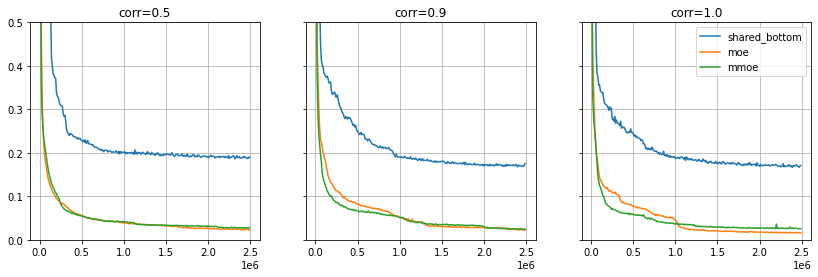

In [15]:
f, ax = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
for i, task_corr in enumerate([0.5, 0.9, 1.0]):
    ax[i].plot(shared_bottom_stats[task_corr][1:], label='shared_bottom')
    ax[i].plot(moe_stats[task_corr][1:], label='moe')
    ax[i].plot(mmoe_stats[task_corr][1:], label='mmoe')
    ax[i].set_title(f"corr={task_corr}")
    ax[i].grid()

ax[-1].legend()
ax[-1].set_ylim(0, 0.5)